In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# Leitura de dados

In [124]:
# Resultados
df_resultados = pd.read_csv('resultados_instancias_tcc.csv')
df_resultados = df_resultados[['Instancias'] + [col for col in df_resultados.columns if col.startswith('Obj_') or col.startswith('Time_')]]
df_resultados = df_resultados[df_resultados['Obj_RF_T_0'] != np.inf]  # Remove infactíveis

In [125]:
# Features criadas de create_features_dataset.py
df_features = pd.read_csv('multi_plant_instance_features.csv')

In [126]:
df = df_features.merge(df_resultados, left_on='instance', right_on='Instancias', how='inner').drop(columns=['Instancias', 'instance'])

In [127]:
df.head()

,num_products,num_plants,num_periods,total_demand,avg_demand_per_product,variance_demand_per_product,std_demand_per_product,mean_utilization,max_utilization,min_utilization,...,Obj_RF_4_2,Time_RF_4_2,Obj_RF_4_3,Time_RF_4_3,Obj_RF_6_0,Time_RF_6_0,Obj_RF_6_1,Time_RF_6_1,Obj_RF_T_0,Time_RF_T_0
0,120,2,12,263136,91.366667,2807.950972,52.990103,1.000118,1.067356,0.935956,...,NaN,NaN,NaN,NaN,829221.10,1800.13,811118.49,1200.63,809910.65,1800.1
1,60,20,12,1305703,90.673819,2699.046453,51.952348,1.000154,1.143479,0.839942,...,NaN,NaN,NaN,NaN,2404264.97,1069.06,2404219.27,1018.31,2404240.72,952.5
2,120,6,12,788211,91.228125,2765.053630,52.583777,0.999516,1.092181,0.870333,...,NaN,NaN,NaN,NaN,2000140.81,1800.32,1991086.02,1214.94,2106419.81,1800.2
3,10,2,12,21517,89.654167,3041.942899,55.153811,1.115449,1.366064,0.730916,...,NaN,NaN,NaN,NaN,53016.54,38.56,52972.47,25.05,52922.30,687.8
4,120,4,12,523216,90.836111,2675.219668,51.722526,1.110871,1.203943,1.008591,...,NaN,NaN,NaN,NaN,1428889.42,1800.16,1431905.66,1203.04,1758853.57,1800.6


# Construção de targets

In [128]:
obj_columns = [col for col in df.columns if col.startswith('Obj_')]
time_columns = [col for col in df.columns if col.startswith('Time_')]

## Target em função objetivo (BEST)

In [129]:
# Seleciona para cada instância o método com menor função objetivo para a coluna BEST
df['BEST'] = df[obj_columns].idxmin(axis=1)
df['BEST'] = df['BEST'].str.replace('Obj_', '')

In [130]:
df['BEST'].value_counts()

BEST
RF_T_0    221
RF_6_0     73
RF_3_1     60
RF_2_0     52
RF_1_0     48
RF_6_1     45
RF_2_1     36
RF_3_0     33
RF_4_0     30
Name: count, dtype: int64

## Target com compromisso de tempo (BEST_TIME)

In [131]:
# Seleciona para cada instância o método com melhor relação função objetivo e tempo para a coluna BEST_TIME
# O compromisso com tempo 

# Preprocessamento de dados

## Drop Obj_ e Time_

In [132]:
df = df.drop(columns=obj_columns + time_columns)

# Train e test split

In [133]:
df.head()

,num_products,num_plants,num_periods,total_demand,avg_demand_per_product,variance_demand_per_product,std_demand_per_product,mean_utilization,max_utilization,min_utilization,...,variance_production_cost,std_production_cost,total_transportation_cost,avg_inventory_cost,variance_inventory_cost,demand_to_capacity_ratio,setup_to_production_cost_ratio,avg_demand_to_setup_cost_ratio,total_cost_to_demand_ratio,BEST
0,120,2,12,263136,91.366667,2807.950972,52.990103,1.000118,1.067356,0.935956,...,0.075604,0.274962,0.60,0.297917,0.005287,0.275723,261.135731,0.174541,0.479271,RF_T_0
1,60,20,12,1305703,90.673819,2699.046453,51.952348,1.000154,1.143479,0.839942,...,0.081440,0.285377,115.98,0.300667,0.005066,0.286716,24.361559,1.865822,0.046496,RF_4_0
2,120,6,12,788211,91.228125,2765.053630,52.583777,0.999516,1.092181,0.870333,...,0.089082,0.298466,9.16,0.300972,0.005263,0.305485,249.786022,0.182511,0.458421,RF_1_0
3,10,2,12,21517,89.654167,3041.942899,55.153811,1.115449,1.366064,0.730916,...,0.089275,0.298789,0.72,0.295000,0.005475,0.327026,29.803279,1.408992,0.061128,RF_T_0
4,120,4,12,523216,90.836111,2675.219668,51.722526,1.110871,1.203943,1.008591,...,0.079851,0.282579,4.20,0.300208,0.005437,0.333647,248.790197,0.182385,0.458746,RF_2_0


In [134]:
X, y = df.drop(columns='BEST'), df['BEST']

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2112)

In [136]:
X_train

,num_products,num_plants,num_periods,total_demand,avg_demand_per_product,variance_demand_per_product,std_demand_per_product,mean_utilization,max_utilization,min_utilization,...,avg_production_cost,variance_production_cost,std_production_cost,total_transportation_cost,avg_inventory_cost,variance_inventory_cost,demand_to_capacity_ratio,setup_to_production_cost_ratio,avg_demand_to_setup_cost_ratio,total_cost_to_demand_ratio
135,60,6,12,393203,91.019213,2798.271159,52.898688,1.000213,1.164670,0.872732,...,2.015000,0.088386,0.297298,9.56,0.300278,0.004861,0.290737,238.112076,0.189704,0.441126
255,60,20,12,1297947,90.135208,2718.015260,52.134588,1.110904,1.295521,0.861345,...,1.983833,0.085755,0.292840,115.38,0.301417,0.005306,0.316877,257.139335,0.176694,0.473460
284,10,20,12,214588,89.411667,2619.863031,51.184598,0.999533,1.410111,0.515096,...,1.975500,0.096250,0.310241,112.32,0.301000,0.005599,0.286939,276.450519,0.163719,0.510843
545,120,20,12,2613563,90.748715,2702.933835,51.989747,0.999954,1.134924,0.863795,...,2.006750,0.086604,0.294286,114.90,0.298583,0.005015,0.299153,25.246501,1.791208,0.048366
133,10,4,12,41739,86.956250,2609.708503,51.085306,1.112443,1.550377,0.787311,...,1.977500,0.093744,0.306176,3.38,0.307500,0.005194,0.303645,253.005057,0.173802,0.481368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,60,2,12,127578,88.595833,2489.935260,49.899251,0.998481,1.110632,0.896909,...,2.002500,0.096410,0.310500,0.56,0.296667,0.005822,0.303610,255.814399,0.172948,0.483724
389,120,6,12,784969,90.852894,2711.919216,52.076091,1.110881,1.204749,1.000858,...,1.999306,0.090597,0.300993,9.34,0.299028,0.004957,0.311842,24.495241,1.855145,0.046754
385,10,15,12,166837,92.687222,2771.823837,52.648113,0.999114,1.380391,0.560530,...,2.068000,0.069776,0.264151,61.86,0.294000,0.005231,0.303408,23.672147,1.893353,0.045873
166,120,20,12,2613563,90.748715,2702.933835,51.989747,0.999954,1.128922,0.870785,...,2.006750,0.086604,0.294286,114.90,0.298583,0.005015,0.285136,252.464121,0.179121,0.467077


# Var preprocessing

In [139]:
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

In [140]:
categorical_features

Index([], dtype='object')

# Modelos

Num primeiro momento vou testar diversos algoritmos antes de buscar precisão. Ainda tenho algum trabalho de feature engineering para ter tudo afinado.

In [137]:
# Inicialização dos classificadores
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=2112),
    'Random Forest': RandomForestClassifier(random_state=2112)
}

# Teste dos classificadores em bulk
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Treinos
    y_pred = clf.predict(X_test)  # Previsões
    acc = accuracy_score(y_test, y_pred)  # Precisão
    print(f'{name} Accuracy: {acc:.2f}')

Gradient Boosting Accuracy: 0.53
Random Forest Accuracy: 0.55


Gradient Boosting Accuracy: 0.53


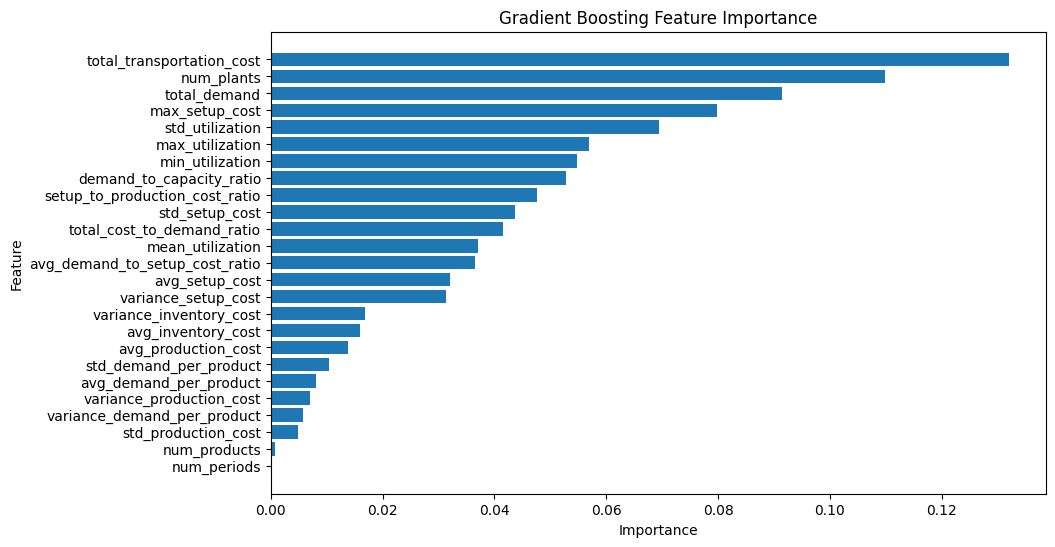

Random Forest Accuracy: 0.55


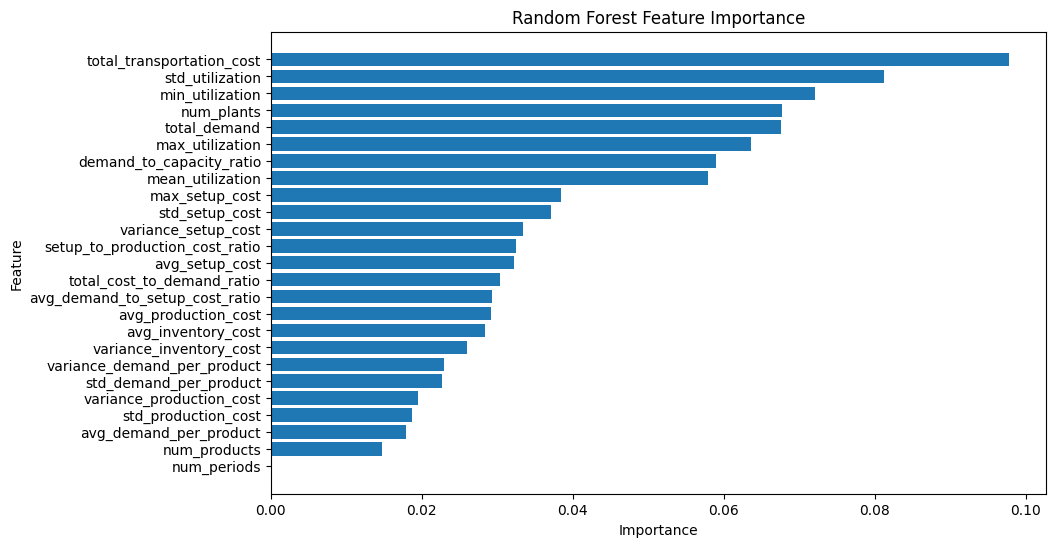

In [138]:
# Train and evaluate models, extracting feature importance
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train the model
    y_pred = clf.predict(X_test)  # Predict
    acc = accuracy_score(y_test, y_pred)  # Accuracy
    print(f'{name} Accuracy: {acc:.2f}')
    
    # Feature importance
    importance = clf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'{name} Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()


In [152]:
# Create a pipeline with RFE and RandomForest
pipeline = Pipeline(steps=[
    ('feature_selection', RFE(estimator=RandomForestClassifier(random_state=2112), n_features_to_select=3)),
    ('classifier', RandomForestClassifier(random_state=2112))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the model
accuracy = pipeline.score(X_test, y_test)
print(f'Pipeline Accuracy with Selected Features: {accuracy:.2f}')

Pipeline Accuracy with Selected Features: 0.56


In [159]:
# Perform RFE to select top N features
n_features_to_select = 3
rfe = RFE(estimator=RandomForestClassifier(random_state=2112), n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features_mask = rfe.support_  # Boolean mask for selected features
selected_features = X_train.columns[selected_features_mask]
print(f'Top {n_features_to_select} Features:', selected_features.tolist())

Top 3 Features: ['std_utilization', 'avg_setup_cost', 'total_transportation_cost']


In [160]:
# Filter the training and testing data to keep only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the model using selected features
clf = RandomForestClassifier(random_state=2112)
clf.fit(X_train_selected, y_train)

# Evaluate the model
accuracy = clf.score(X_test_selected, y_test)
print(f'Accuracy with Selected Features: {accuracy:.2f}')

Accuracy with Selected Features: 0.56


In [161]:
X_train_selected

,std_utilization,avg_setup_cost,total_transportation_cost
135,0.062521,479.795833,9.56
255,0.073276,510.121583,115.38
284,0.157105,546.128000,112.32
545,0.046738,50.663417,114.90
133,0.184606,500.317500,3.38
...,...,...,...
57,0.059950,512.268333,0.56
389,0.047504,48.973472,9.34
385,0.158498,48.954000,61.86
166,0.044540,506.632375,114.90
